# Memmory plots for Tegrastats logs

#### Globals and imports

In [60]:
import re
import matplotlib.pyplot as plt

### Functions

In [61]:
# Función para analizar una línea de estadísticas
# 03-17-2024 18:54:10 RAM 10239/62841MB (lfb 442x4MB) SWAP 1/31421MB (cached 0MB) CPU [0%@1728,0%@1728,0%@1728,0%@1728,0%@1420,0%@1420,0%@1420,0%@1420,off,off,off,off] GR3D_FREQ 0% cpu@37.5C tboard@27C soc2@34.562C tdiode@27.5C soc0@34.531C tj@37.5C soc1@33.656C VDD_GPU_SOC 1592mW/1592mW VDD_CPU_CV -398mW/-398mW VIN_SYS_5V0 2624mW/2624mW VDDQ_VDD2_1V8AO 403mW/403mW
def parse_line(line):
    stats = {}
    parts = line.split()
    stats['time'] = parts[0] + ' ' + parts[1]
    stats['RAM'] = int(parts[3].split('/')[0])
    stats['maxRAM'] = int(parts[3].split('/')[1].split('M')[0])
    stats['SWAP'] = int(parts[7].split('/')[0])
    stats['maxSWAP'] = int(parts[7].split('/')[1].split('M')[0])
    stats['CPU'] = parts[11].strip('[]').split(',')
    stats['GR3D_FREQ'] = int(parts[13].split('%')[0])
    # Agrega aquí más métricas según sea necesario.
    return stats

In [62]:
# Leer datos de los archivos y almacenar en diccionarios
def read_data(file_path):
    data = {'time': [], 'RAM': [], 'SWAP': [], 'GR3D_FREQ': [], 'CPU': [], 'CPU_FREQ': [], 'maxRAM': 0, 'maxSWAP': 0}
    with open(file_path, 'r') as file:
        first_line = True
        time_ms = 0  # Inicializa el contador de tiempo en 0
        for line in file:
            if line.strip():
                stats = parse_line(line)
                if first_line:
                    # Extrae maxRAM y maxSWAP solo de la primera línea
                    data['maxRAM'] = stats['maxRAM']
                    data['maxSWAP'] = stats['maxSWAP']
                    first_line = False
                 # Calcula el promedio del uso de CPU y la frecuencia
                cpu_usage_sum = 0
                cpu_freq_sum = 0
                cpu_count = 0
                for cpu in stats['CPU']:
                    if cpu != 'off':
                        usage, freq = cpu.split('@')
                        cpu_usage_sum += int(usage[:-1])  # Elimina el signo % y convierte a int
                        cpu_freq_sum += int(freq)
                        cpu_count += 1
                
                # Solo añade valores si hay CPUs activos
                if cpu_count > 0:
                    avg_cpu_usage = cpu_usage_sum / cpu_count
                    avg_cpu_freq = cpu_freq_sum / cpu_count
                else:
                    avg_cpu_usage = 0
                    avg_cpu_freq = 0

                data['CPU'].append(avg_cpu_usage)
                data['CPU_FREQ'].append(avg_cpu_freq)
                data['time'].append(time_ms)
                data['RAM'].append(stats['RAM'])
                data['SWAP'].append(stats['SWAP'])
                data['GR3D_FREQ'].append(stats['GR3D_FREQ'])
                # Incrementa el contador de tiempo en 1 milisegundo para el siguiente registro
                time_ms += 1 # estamos probando tegrastats a una taza de sampleo de 1 ms
    return data

In [69]:
def plot_data(metrics, labels, title):
    # Extraer maxRAM y maxSWAP de los datos (asumiendo que son constantes)
    maxRAM = metrics[0]['maxRAM'] / 1024  # Convertir de MB a GB
    maxSWAP = metrics[0]['maxSWAP'] / 1024  # Convertir de MB a GB

    # Configurar parámetros de la fuente
    plt.rcParams.update({'font.size': 14})

    # Crear figura y ejes
    plt.figure(figsize=(10, 7)).tight_layout()

    # Colores específicos para cada etiqueta
    color_dict = {'Vanilla':'tab:blue', 'TRT fp32':'tab:orange', 'TRT fp16':'tab:green', 'TRT int8':'tab:red'}  # Añadir más etiquetas si es necesario

    # Graficar RAM
    for index, (metric, label) in enumerate(zip(metrics, labels)):
        ram_in_gb = [ram / 1024 for ram in metric['RAM']]  # Convertir RAM a GB
        color = color_dict.get(label, None)  # Obtener color del diccionario o usar el predeterminado
        plt.plot(metric['time'], ram_in_gb, label=f'RAM {label}', color=color)
        max_ram = max(ram_in_gb)
        avg_ram = sum(ram_in_gb) / len(ram_in_gb)

        print(f'Max RAM {label}: {max_ram:.2f} GB, Avg RAM {label}: {avg_ram:.2f} GB')

    # Graficar SWAP
    for index, (metric, label) in enumerate(zip(metrics, labels)):
        swap_in_gb = [swap / 1024 for swap in metric['SWAP']]  # Convertir SWAP a GB
        color = color_dict.get(label, None)  # Obtener el mismo color para la misma etiqueta
        plt.plot(metric['time'], swap_in_gb, label=f'SWAP {label}', linestyle='--', color=color)  # Línea punteada para SWAP
        max_swap = max(swap_in_gb)
        avg_swap = sum(swap_in_gb) / len(swap_in_gb)

        print(f'Max SWAP {label}: {max_swap:.2f} GB, Avg SWAP {label}: {avg_swap:.2f} GB')

    # Configurar título y etiquetas
    plt.title(f'{title} - RAM and SWAP Usage')
    plt.xlabel('Time ms')
    plt.ylabel('Usage (GB)')
    plt.ylim(0, max(maxRAM, maxSWAP / 1024))  # Asegurar que el eje Y sea adecuado para ambas series
    plt.legend()
    plt.grid(True)
    plt.grid(which='major', linestyle='-', linewidth='0.5', color='grey')  # Ajusta la grilla principal
    plt.grid(which='minor', linestyle=':', linewidth='0.5', color='lightgrey')  # Ajusta la grilla secundaria
    plt.minorticks_on()
    plt.xticks(rotation=45)
    plt.tight_layout()

    # Mostrar gráfico
    plt.show()


Max RAM Vanilla: 16.33 GB, Avg RAM Vanilla: 14.06 GB
Max RAM TRT fp32: 14.62 GB, Avg RAM TRT fp32: 12.24 GB
Max RAM TRT fp16: 12.29 GB, Avg RAM TRT fp16: 11.18 GB
Max RAM TRT int8: 11.41 GB, Avg RAM TRT int8: 10.67 GB
Max SWAP Vanilla: 0.00 GB, Avg SWAP Vanilla: 0.00 GB
Max SWAP TRT fp32: 0.00 GB, Avg SWAP TRT fp32: 0.00 GB
Max SWAP TRT fp16: 0.00 GB, Avg SWAP TRT fp16: 0.00 GB
Max SWAP TRT int8: 0.00 GB, Avg SWAP TRT int8: 0.00 GB


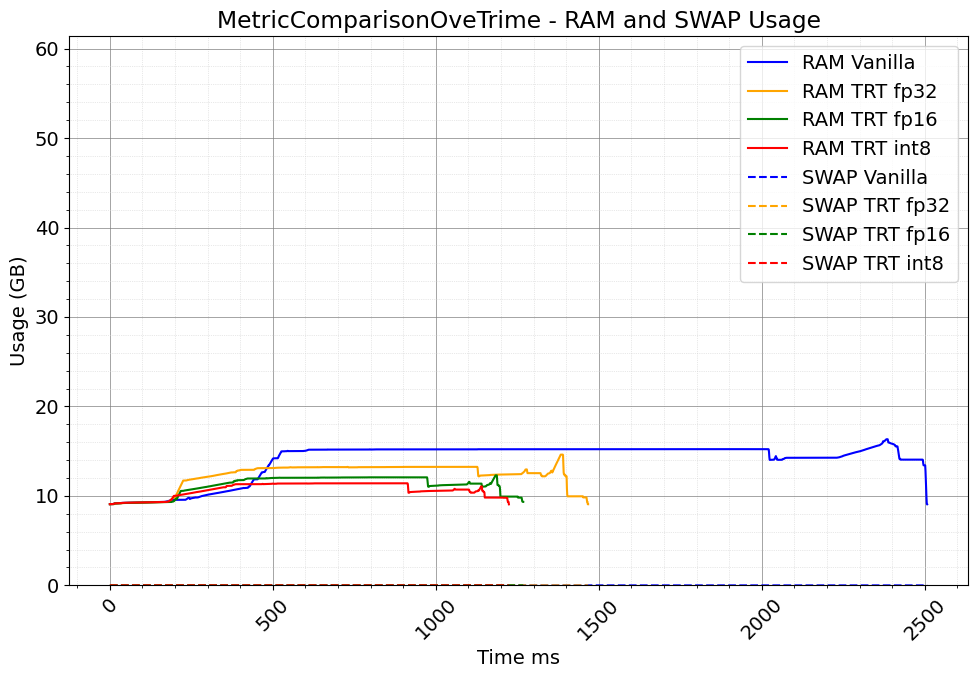

In [70]:
# Leer datos de cada optimización
data_vanilla =  read_data('../outputs/tegrastats_log/tegrastats_log_orin_agx/vanilla_resnet152_bs_256_PW0.txt')
data_trt_fp32 = read_data('../outputs/tegrastats_log/tegrastats_log_orin_agx/fp32_resnet152_bs_256_PW0.txt')
data_trt_fp16 = read_data('../outputs/tegrastats_log/tegrastats_log_orin_agx/fp16_resnet152_bs_256_PW0.txt')
data_trt_int8 = read_data('../outputs/tegrastats_log/tegrastats_log_orin_agx/int8_resnet152_bs_256_PW0.txt')

# Graficar los datos
plot_data(
    [ data_vanilla, data_trt_fp32, data_trt_fp16,data_trt_int8],
    [ 'Vanilla', 'TRT fp32', 'TRT fp16', 'TRT int8'],
    'MetricComparisonOveTrime'
)
#[ data_vanilla, data_trt_fp32, data_trt_fp16, data_trt_int8],
#[ 'Vanilla', 'TRT fp32', 'TRT fp16', 'TRT INT8'],